In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from neurodynex. tools import input_factory


WARNING    D:\Programas\Miniconda2\envs\bmnn\lib\site-packages\ipykernel_launcher.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
 [py.warnings]
WARNING    "i" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 1000099. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


nr of spikes: 71705
The Coefficient of Variation (CV) is in percetange of: 50.9955692947


<Figure size 432x288 with 0 Axes>

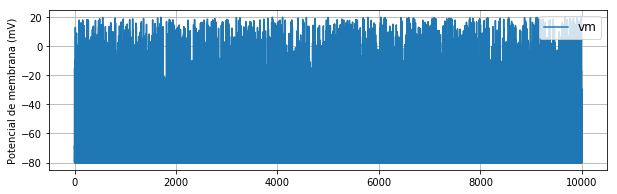

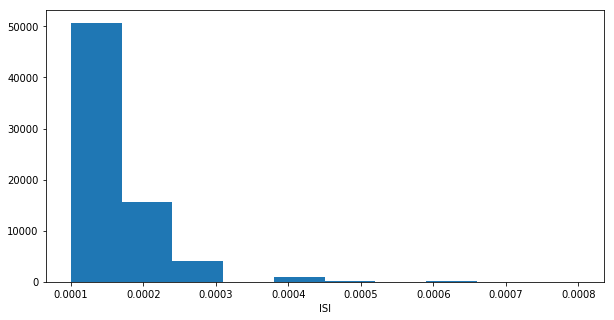

In [3]:
v_rest= -70*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0*b2.nA

tau_w = 150*b2.ms
v_max = 20*b2.mV

simulation_time = 10000
dt =  0.01*b2.ms 

t_start=0
t_end=simulation_time
sigma = 50*b2.pA
dt_cur = 0.01
sigma = sigma/(np.sqrt(dt_cur))
mi=0
unit_time=b2.ms

tmp_size = 1 + t_end  # +1 for t=0

tmp = np.zeros((tmp_size/dt_cur, 1)) * b2.pA
size=3000
x = np.linspace(-size, size, size/dt_cur) * b2.pA
normal = np.asarray((1/np.sqrt(2*math.pi*sigma**2))*math.e**(-((x-mi)**2)/(2*sigma**2)))
fig = plt.figure()
# plt.plot(x, normal)
# plt.show()
normal = normal*b2.pA
for i in range(int(tmp_size/dt_cur)):
    tmp[i, 0] = random.choice(normal)

input_current = b2.TimedArray(tmp, dt=dt)
    
eqs = """
dv/dt = (conductance_L/membrane_capacitance)*
        (v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current(t,i)/membrane_capacitance) : volt
dw/dt = (a*(v-v_rest)-w)/tau_w :  amp
"""
neuron = b2.NeuronGroup(1, model=eqs, reset="v=v_reset; w=w+b",
                        threshold="v>v_max", method="euler")
neuron.v = v_rest
neuron.w = 0*b2.pA

# monitoring membrane potential of neuron and injecting current
state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
spike_monitor = b2.SpikeMonitor(neuron)
# run the simulation
b2.run(simulation_time*b2.ms)

print("nr of spikes: {}".format(spike_monitor.count[0]))

#plot
fig = plt.figure(figsize=(10,10))

fig.add_subplot(3,1,2)
plt.plot(state_monitor.t/b2.ms, state_monitor.v[0]/b2.mV)

plt.ylabel('Potencial de membrana (mV)')
plt.grid()
plt.legend(["vm", "firing threshold"], fontsize=12)

plt.show()

vector = list()
spikes = spike_monitor.count[:]
inter = np.full(len(spikes[:]), np.nan)

for k in range(len(spike_monitor.t)-1):
    inter = (float(spike_monitor.spike_trains()[0][k+1]) - float(spike_monitor.spike_trains()[0][k]));
    vector.append(inter)
        
fig = plt.figure(figsize=(10, 5))
plt.hist(vector, 10)
plt.xlabel('ISI')

isi_mu = np.mean(vector)
isi_std = np.std(vector)
CV = isi_std*100/isi_mu
print("The Coefficient of Variation (CV) is in percetange of: %s" % CV)
  

In [4]:
v_rest= -70*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0*b2.nA

tau_w = 150*b2.ms
v_max = 20*b2.mV

simulation_time = 10000
dt =  0.01*b2.ms 

#current = 200.01 * b2.pamp
current = 500*b2.pA
# input_current = input_factory.get_step_current(
# t_start=500, t_end=1000, unit_time=b2.ms,
# amplitude=current*b2.pA) 

t_start=0
t_end=simulation_time
sigma = 50*b2.pA
dt_cur = 0.01
sigma = sigma/(np.sqrt(dt_cur))
mi=0
unit_time=b2.ms

tmp_size = 1 + t_end  # +1 for t=0

tmp = np.zeros((tmp_size/dt_cur, 1)) * b2.pA
size=3000
x = np.linspace(-size, size, size/dt_cur) * b2.pA
normal = np.asarray((1/np.sqrt(2*math.pi*sigma**2))*math.e**(-((x-mi)**2)/(2*sigma**2)))
fig = plt.figure()
# plt.plot(x, normal)
# plt.show()
normal = normal*b2.pA
for i in range(int(tmp_size/dt_cur)):
    tmp[i, 0] = random.choice(normal)
input_current = b2.TimedArray(tmp, dt=dt)
    
eqs = """

dv/dt = (conductance_L/membrane_capacitance)*
        (v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current(t,i)/membrane_capacitance) : volt
dw/dt = (a*(v-v_rest)-w)/tau_w :  amp
"""
neuron = b2.NeuronGroup(1, model=eqs, reset="v=v_reset; w=w+b",
                        threshold="v>v_max", method="euler")
neuron.v = v_rest
neuron.w = 0*b2.pA

# run the simulation
aux=[]
for j in range(100):
    state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    b2.run(100*b2.ms)
    aux.append(spike_monitor.count[:])
    
print("ALL FANOs: {}".format(aux))
mean = np.mean(aux)
var = np.var(aux)
print("FANO: {}".format(var/mean))


WARNING    D:\Programas\Miniconda2\envs\bmnn\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
 [py.warnings]


ALL FANOs: [array([723]), array([710]), array([711]), array([722]), array([729]), array([727]), array([732]), array([694]), array([715]), array([727]), array([723]), array([707]), array([715]), array([719]), array([723]), array([719]), array([687]), array([705]), array([714]), array([718]), array([714]), array([724]), array([703]), array([715]), array([736]), array([713]), array([711]), array([705]), array([718]), array([738]), array([725]), array([727]), array([712]), array([721]), array([724]), array([714]), array([726]), array([732]), array([705]), array([735]), array([676]), array([714]), array([737]), array([718]), array([707]), array([722]), array([702]), array([745]), array([695]), array([706]), array([727]), array([722]), array([715]), array([709]), array([706]), array([710]), array([697]), array([703]), array([744]), array([734]), array([697]), array([735]), array([712]), array([707]), array([706]), array([716]), array([724]), array([715]), array([715]), array([728]), array([7

<Figure size 432x288 with 0 Axes>

WARNING    D:\Programas\Miniconda2\envs\bmnn\lib\site-packages\ipykernel_launcher.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
 [py.warnings]
WARNING    "i" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 100099. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


<Figure size 432x288 with 0 Axes>

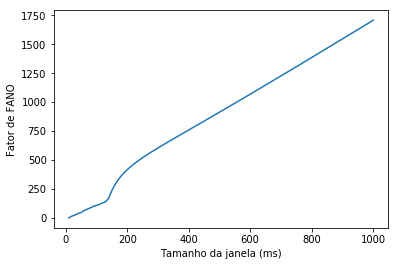

In [2]:
v_rest= -70*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0*b2.nA

tau_w = 150*b2.ms
v_max = 20*b2.mV

simulation_time = 1000
dt =  0.01*b2.ms 

append_zero=True
t_start=0
t_end=simulation_time
sigma = 50*b2.pA
dt_cur = 0.01
sigma = sigma/(np.sqrt(dt_cur))
mi=0
unit_time=b2.ms

tmp_size = 1 + t_end    
tmp = np.zeros((tmp_size/dt_cur, 1)) * b2.pA

size=3000
x = np.linspace(-size, size, size/dt_cur) * b2.pA
normal = np.asarray((1/np.sqrt(2*math.pi*sigma**2))*math.e**(-((x-mi)**2)/(2*sigma**2)))
fig = plt.figure()
normal = normal*b2.pA
for i in range(int(tmp_size/dt_cur)):
    tmp[i, 0] = random.choice(normal)
input_current = b2.TimedArray(tmp, dt=dt)

eqs = """
dv/dt = (conductance_L/membrane_capacitance)*
        (v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current(t,i)/membrane_capacitance) : volt
dw/dt = (a*(v-v_rest)-w)/tau_w :  amp
"""
neuron = b2.NeuronGroup(1, model=eqs, reset="v=v_reset; w=w+b",
                        threshold="v>v_max", method="euler")
neuron.v = v_rest
neuron.w = 0*b2.pA

# monitoring membrane potential of neuron and injecting current
state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
spike_monitor = b2.SpikeMonitor(neuron)

auxi=[]
win=[]
fano=[]
for z in range(100):
    state_monitor = b2.StateMonitor(neuron, ["v"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    b2.run(10*(z+1)*b2.ms)
    win.append(10*(z+1))
    auxi.append(spike_monitor.count[:])
    mean = np.mean(auxi)
    var = np.var(auxi)
    fano.append(var/mean)

plt.figure()
plt.plot(win, fano)
plt.xlabel('Tamanho da janela (ms)')
plt.ylabel('Fator de FANO')
plt.show()
